In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
# Mount the drive.
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/

Mounted at /content/drive
MyDrive  Shareddrives


In [ ]:
datasets = {
    'Aug 2023': pd.read_csv('/content/kenny_baseline_data - kenny_aug_2023.csv'),
    'Aug 2024': pd.read_csv('/content/kenny_baseline_data - kenny_aug_2024.csv'),
    'Jan 2024': pd.read_csv('/content/kenny_baseline_data - kenny_jan_2024.csv'),
    'Jan 2025': pd.read_csv('/content/kenny_baseline_data -  kenny_jan_2025.csv')
}

In [ ]:
# Combine date and time into datetime
for name, df in datasets.items():
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df['hour'] = df['datetime'].dt.hour

In [ ]:
# ============================================
# TASK 1: Summer vs Winter Usage Summary
# ============================================
print("=" * 60)
print("TASK 3.1: SEASONAL USAGE SUMMARY")
print("=" * 60)

summary_data = []
for name, df in datasets.items():
    daily_totals = df.groupby(df['datetime'].dt.date)['usage_therms'].sum()
    hourly_peaks = df.groupby(df['datetime'].dt.date)['usage_therms'].max()
    zero_hours = (df['usage_therms'] == 0).sum() / len(df) * 100

    summary_data.append({
        'Month': name,
        'Avg Daily Therms': round(daily_totals.mean(), 2),
        'Avg Hourly Peak': round(hourly_peaks.mean(), 2),
        'Zero-Usage Hours %': round(zero_hours, 1)
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print()

TASK 3.1: SEASONAL USAGE SUMMARY
   Month  Avg Daily Therms  Avg Hourly Peak  Zero-Usage Hours %
Aug 2023              0.25             0.08                69.0
Aug 2024              0.15             0.05                76.2
Jan 2024              2.95             0.42                22.7
Jan 2025              2.90             0.30                17.1



In [ ]:
# ============================================
# TASK 2: Temperature-Usage Correlation (Winter)
# ============================================
print("=" * 60)
print("TASK 3.2: TEMPERATURE-USAGE CORRELATION (WINTER ONLY)")
print("=" * 60)

for name, df in datasets.items():
    if 'Jan' in name:  # Winter months only
        print(f"\n{name}:")

        # Temperature bins
        temp_bins = [
            (df['temp'] < 50, 'Below 50°F'),
            ((df['temp'] >= 50) & (df['temp'] < 65), '50-65°F'),
            (df['temp'] >= 65, 'Above 65°F')
        ]

        for condition, label in temp_bins:
            filtered = df[condition]
            if len(filtered) > 0:
                avg_usage = filtered['usage_therms'].mean()
                print(f"  {label}: Avg {avg_usage:.3f} therms/hour ({len(filtered)} hours)")

print()

TASK 3.2: TEMPERATURE-USAGE CORRELATION (WINTER ONLY)

Jan 2024:
  Below 50°F: Avg 0.167 therms/hour (371 hours)
  50-65°F: Avg 0.083 therms/hour (316 hours)
  Above 65°F: Avg 0.057 therms/hour (57 hours)

Jan 2025:
  Below 50°F: Avg 0.156 therms/hour (367 hours)
  50-65°F: Avg 0.090 therms/hour (299 hours)
  Above 65°F: Avg 0.072 therms/hour (78 hours)



TASK 3.3: HOURLY USAGE PATTERNS BY SEASON
✓ Hourly usage pattern chart saved as 'hourly_usage_patterns.png'


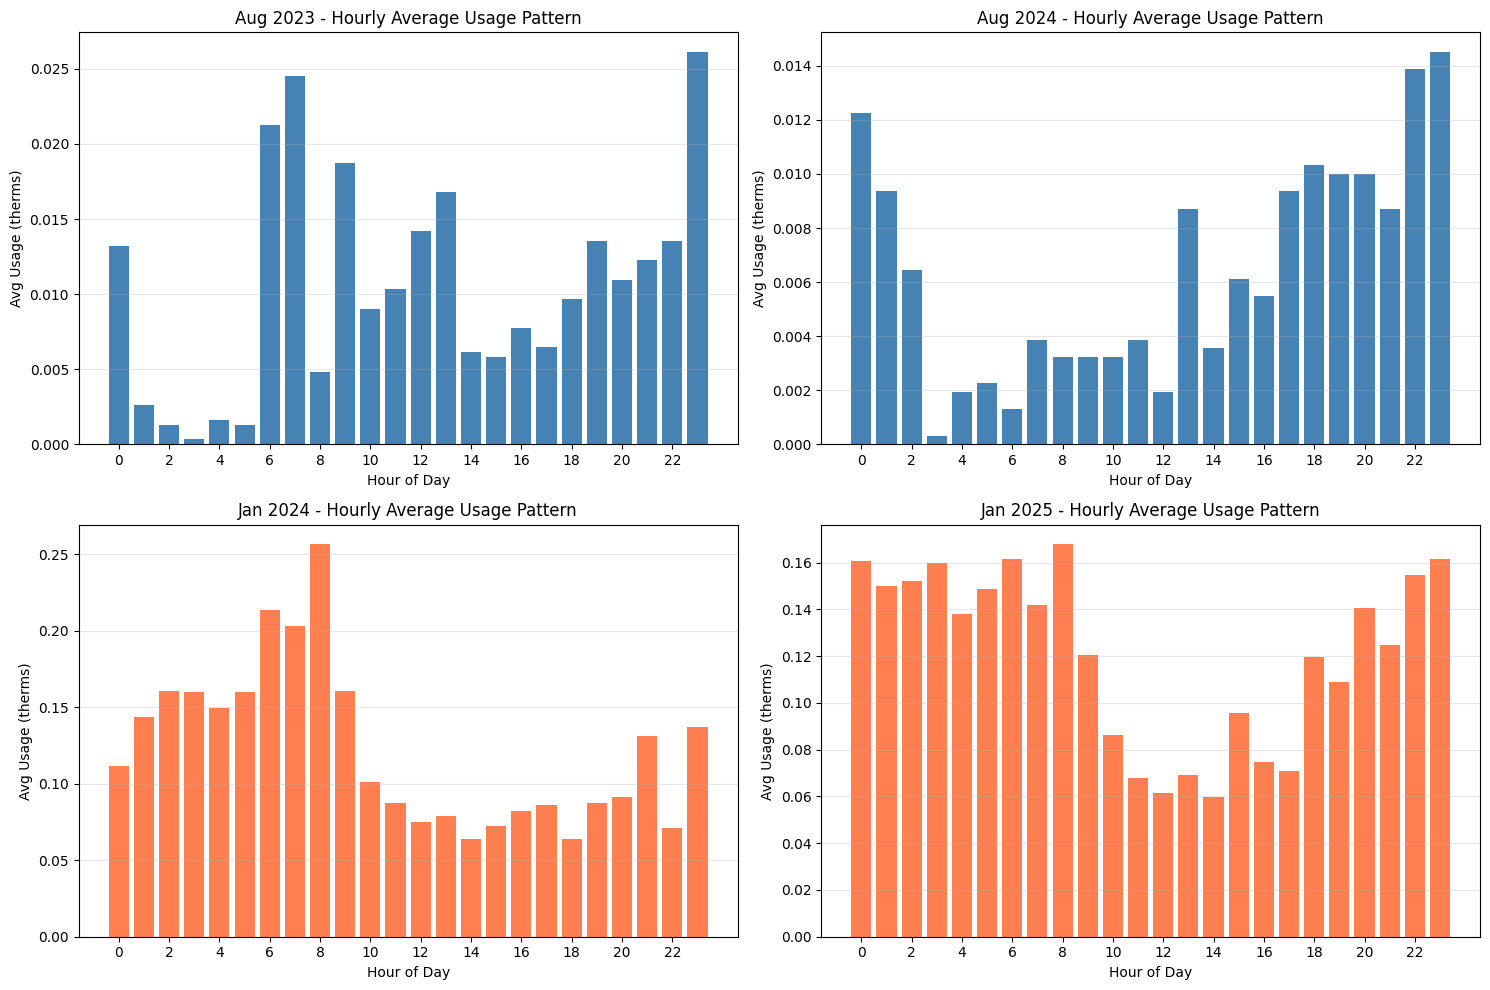

In [ ]:
# ============================================
# TASK 3: Heating vs Non-Heating Signatures
# ============================================
print("=" * 60)
print("TASK 3.3: HOURLY USAGE PATTERNS BY SEASON")
print("=" * 60)

# Calculate average usage by hour for each dataset
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(datasets.items()):
    hourly_avg = df.groupby('hour')['usage_therms'].mean()

    axes[idx].bar(hourly_avg.index, hourly_avg.values, color='steelblue' if 'Aug' in name else 'coral')
    axes[idx].set_title(f'{name} - Hourly Average Usage Pattern')
    axes[idx].set_xlabel('Hour of Day')
    axes[idx].set_ylabel('Avg Usage (therms)')
    axes[idx].set_xticks(range(0, 24, 2))
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('hourly_usage_patterns.png', dpi=300, bbox_inches='tight')
print("✓ Hourly usage pattern chart saved as 'hourly_usage_patterns.png'")

In [ ]:
# Print peak usage hours
print("\nPeak Usage Hours by Season:")
for name, df in datasets.items():
    hourly_avg = df.groupby('hour')['usage_therms'].mean()
    top_3_hours = hourly_avg.nlargest(3)
    print(f"\n{name}:")
    for hour, usage in top_3_hours.items():
        print(f"  {hour:02d}:00 - {usage:.3f} therms/hour")


Peak Usage Hours by Season:

Aug 2023:
  23:00 - 0.026 therms/hour
  07:00 - 0.025 therms/hour
  06:00 - 0.021 therms/hour

Aug 2024:
  23:00 - 0.015 therms/hour
  22:00 - 0.014 therms/hour
  00:00 - 0.012 therms/hour

Jan 2024:
  08:00 - 0.256 therms/hour
  06:00 - 0.214 therms/hour
  07:00 - 0.203 therms/hour

Jan 2025:
  08:00 - 0.168 therms/hour
  06:00 - 0.162 therms/hour
  23:00 - 0.162 therms/hour


In [ ]:
# ============================================
# TASK 4: Heating Threshold Analysis
# ============================================
print("\n" + "=" * 60)
print("TASK 3.4: HEATING THRESHOLD IDENTIFICATION")
print("=" * 60)

# For winter months, find temperature where heating usage increases
for name, df in datasets.items():
    if 'Jan' in name:
        print(f"\n{name}:")

        # Group by temperature ranges and calculate average usage
        df['temp_bin'] = pd.cut(df['temp'], bins=range(30, 80, 5))
        temp_usage = df.groupby('temp_bin')['usage_therms'].mean().sort_index()

        print("\nTemperature Range → Avg Usage:")
        for temp_range, usage in temp_usage.items():
            if pd.notna(usage):
                print(f"  {temp_range}: {usage:.3f} therms/hour")



TASK 3.4: HEATING THRESHOLD IDENTIFICATION

Jan 2024:

Temperature Range → Avg Usage:
  (30, 35]: 0.243 therms/hour
  (35, 40]: 0.169 therms/hour
  (40, 45]: 0.134 therms/hour
  (45, 50]: 0.127 therms/hour
  (50, 55]: 0.114 therms/hour
  (55, 60]: 0.070 therms/hour
  (60, 65]: 0.059 therms/hour
  (65, 70]: 0.053 therms/hour
  (70, 75]: 0.081 therms/hour

Jan 2025:

Temperature Range → Avg Usage:
  (30, 35]: 0.124 therms/hour
  (35, 40]: 0.165 therms/hour
  (40, 45]: 0.172 therms/hour
  (45, 50]: 0.139 therms/hour
  (50, 55]: 0.103 therms/hour
  (55, 60]: 0.086 therms/hour
  (60, 65]: 0.069 therms/hour
  (65, 70]: 0.072 therms/hour
  (70, 75]: 0.068 therms/hour


/tmp/ipython-input-905130693.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_usage = df.groupby('temp_bin')['usage_therms'].mean().sort_index()
/tmp/ipython-input-905130693.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_usage = df.groupby('temp_bin')['usage_therms'].mean().sort_index()


In [ ]:
# ============================================
# TASK 5: Export Analysis Results
# ============================================
print("\n" + "=" * 60)
print("EXPORTING ANALYSIS RESULTS")
print("=" * 60)


EXPORTING ANALYSIS RESULTS


In [ ]:
# Export summary statistics
summary_df.to_csv('seasonal_usage_summary.csv', index=False)
print("✓ Summary saved to 'seasonal_usage_summary.csv'")

# Export hourly averages for each dataset
for name, df in datasets.items():
    hourly_stats = df.groupby('hour').agg({
        'usage_therms': ['mean', 'std', 'max', 'min'],
        'temp': 'mean'
    }).round(4)
    hourly_stats.columns = ['_'.join(col).strip() for col in hourly_stats.columns.values]

    filename = f"hourly_patterns_{name.replace(' ', '_').lower()}.csv"
    hourly_stats.to_csv(filename)
    print(f"✓ {name} hourly patterns saved to '{filename}'")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE!")
print("=" * 60)
print("\nKey Findings to Use for LLM Generation:")
print("1. Check 'seasonal_usage_summary.csv' for overall patterns")
print("2. Review 'hourly_usage_patterns.png' for visual comparison")
print("3. Use temperature correlation data to set heating thresholds")
print("4. Use hourly patterns to identify cooking vs heating signatures")

✓ Summary saved to 'seasonal_usage_summary.csv'
✓ Aug 2023 hourly patterns saved to 'hourly_patterns_aug_2023.csv'
✓ Aug 2024 hourly patterns saved to 'hourly_patterns_aug_2024.csv'
✓ Jan 2024 hourly patterns saved to 'hourly_patterns_jan_2024.csv'
✓ Jan 2025 hourly patterns saved to 'hourly_patterns_jan_2025.csv'

ANALYSIS COMPLETE!

Key Findings to Use for LLM Generation:
1. Check 'seasonal_usage_summary.csv' for overall patterns
2. Review 'hourly_usage_patterns.png' for visual comparison
3. Use temperature correlation data to set heating thresholds
4. Use hourly patterns to identify cooking vs heating signatures
